# 0. Import Packages 

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.utils as vutils
import torchvision.models as models

from torch import nn, optim
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchvision.models import VGG16_Weights
from torchvision.models import resnet50, ResNet50_Weights

from tqdm.auto import tqdm
from PIL import Image
from jcopdl.callback import Callback, set_config

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

# 1. Data Preprocessing
* Dataset
	* preparing dataset
* Dataloader
	* implementing a custom dataloader class

## 1.1 Dataset

### 1.1.1 Preparing Dataset

#### Look at attributes 

In [3]:
gender_data = pd.read_csv('list_attribute.txt', sep='\s+', skiprows=1, usecols=['Male'])

# Make female = 0, and male = 1
gender_data.loc[gender_data['Male']==-1, 'Male'] = 0

gender_data.head()

Male
000001.jpg     0
000002.jpg     0
000003.jpg     1
000004.jpg     0
000005.jpg     0

#### File images 

In [4]:
folder_path = r'C:\Users\USER\Documents\2023\AI\1. Gender Classification\Images'  # Ganti dengan path folder Anda

# Mengambil semua file dalam folder
files = glob.glob(os.path.join(folder_path, '*'))

# Mengambil nama file dari setiap path file
img_fn = [os.path.basename(file) for file in files]

# Menampilkan nama file
for name in img_fn:
    print(name)

000051.jpg
000052.jpg
000065.jpg
000166.jpg
000198.jpg
000201.jpg
000240.jpg
000282.jpg
000352.jpg
000409.jpg
000414.jpg
000439.jpg
000444.jpg
000474.jpg
000525.jpg
000545.jpg
000559.jpg
000572.jpg
000608.jpg
000653.jpg
000716.jpg
000771.jpg
000798.jpg
000810.jpg
000845.jpg
000858.jpg
000873.jpg
000922.jpg
000989.jpg
001140.jpg
001161.jpg
001218.jpg
001242.jpg
001248.jpg
001256.jpg
001270.jpg
001295.jpg
001401.jpg
001509.jpg
001519.jpg
001613.jpg
001637.jpg
001665.jpg
001708.jpg
001782.jpg
001800.jpg
001894.jpg
001921.jpg
001983.jpg
002085.jpg
002125.jpg
002134.jpg
002150.jpg
002197.jpg
002202.jpg
002223.jpg
002256.jpg
002310.jpg
002362.jpg
002389.jpg
002415.jpg
002427.jpg
002443.jpg
002450.jpg
002456.jpg
002502.jpg
002525.jpg
002527.jpg
002556.jpg
002592.jpg
002598.jpg
002653.jpg
002662.jpg
002663.jpg
002693.jpg
002698.jpg
002747.jpg
002808.jpg
002834.jpg
002903.jpg
003026.jpg
003103.jpg
003148.jpg
003252.jpg
003306.jpg
003354.jpg
003363.jpg
003416.jpg
003427.jpg
003461.jpg
003477.jpg

####  Look at the existing images

In [5]:
existing_gender_data = gender_data[gender_data.index.isin(img_fn)]
existing_gender_data

Male
000051.jpg     1
000052.jpg     1
000065.jpg     1
000166.jpg     1
000198.jpg     0
...          ...
202320.jpg     0
202340.jpg     0
202347.jpg     0
202357.jpg     0
202566.jpg     1

[5000 rows x 1 columns]

In [6]:
existing_gender_data.index

Index(['000051.jpg', '000052.jpg', '000065.jpg', '000166.jpg', '000198.jpg',
       '000201.jpg', '000240.jpg', '000282.jpg', '000352.jpg', '000409.jpg',
       ...
       '201989.jpg', '202045.jpg', '202200.jpg', '202253.jpg', '202276.jpg',
       '202320.jpg', '202340.jpg', '202347.jpg', '202357.jpg', '202566.jpg'],
      dtype='object', length=5000)

#### Check if there is a duplicate data

In [7]:
file_names_not_exist = []
for fn in img_fn:
    if fn not in existing_gender_data.index:
        file_names_not_exist.append(fn)
file_names_not_exist

['182793(1).jpg',
 '182809(1).jpg',
 '182912(1).jpg',
 '182943(1).jpg',
 '183005(1).jpg',
 '183018(1).jpg',
 '183050(1).jpg',
 '183111(1).jpg',
 '183121(1).jpg',
 '183145(1).jpg',
 '189132(1).jpg',
 '189297(1).jpg',
 '189324(1).jpg',
 '189512(1).jpg',
 '189513(1).jpg',
 '189581(1).jpg',
 '189651(1).jpg']

#### Visualize the duplicate images

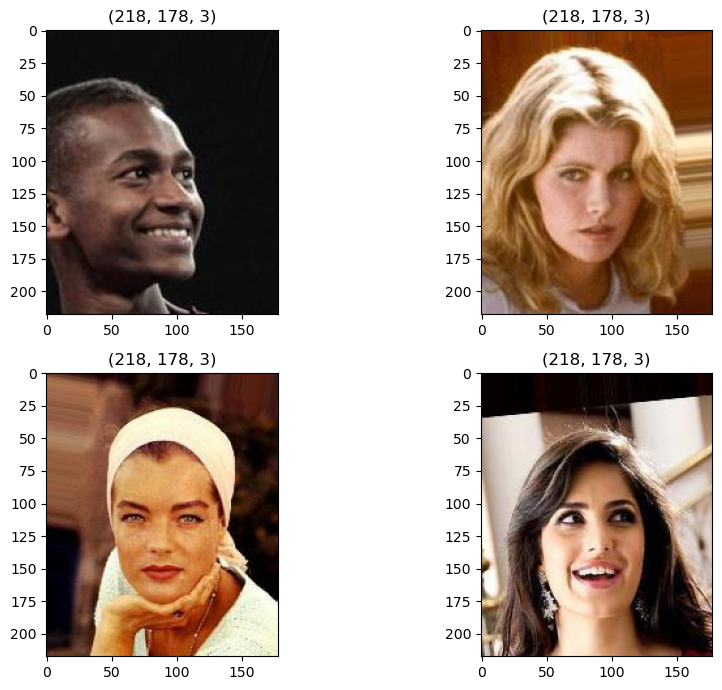

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

images = []
for i in range(4):
    image = plt.imread(folder_path + '/' + file_names_not_exist[i])
    images.append(image)
    axes[i//2, i%2].imshow(image)
    axes[i//2, i%2].set_title(np.asarray(image, dtype=np.uint8).shape)

plt.tight_layout()

#### filtered the gender data based on file images

In [9]:
gender_data = gender_data[gender_data.index.isin(img_fn)]
gender_data

Male
000051.jpg     1
000052.jpg     1
000065.jpg     1
000166.jpg     1
000198.jpg     0
...          ...
202320.jpg     0
202340.jpg     0
202347.jpg     0
202357.jpg     0
202566.jpg     1

[5000 rows x 1 columns]

####  

In [10]:
partition_data = pd.read_csv('list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
partition_data.columns = ['Filename', 'Partition']
partition_data = partition_data.set_index('Filename')

partition_data.head()

Partition
Filename             
000001.jpg          0
000002.jpg          0
000003.jpg          0
000004.jpg          0
000005.jpg          0

In [11]:
celeba_gender_partition = partition_data[partition_data.index.isin(img_fn)]
celeba_gender_partition

Partition
Filename             
000051.jpg          0
000052.jpg          0
000065.jpg          0
000166.jpg          0
000198.jpg          0
...               ...
202320.jpg          2
202340.jpg          2
202347.jpg          2
202357.jpg          2
202566.jpg          2

[5000 rows x 1 columns]

In [12]:
filtered_cgp = gender_data.merge(celeba_gender_partition, left_index=True, right_index=True)
filtered_cgp

Male  Partition
000051.jpg     1          0
000052.jpg     1          0
000065.jpg     1          0
000166.jpg     1          0
000198.jpg     0          0
...          ...        ...
202320.jpg     0          2
202340.jpg     0          2
202347.jpg     0          2
202357.jpg     0          2
202566.jpg     1          2

[5000 rows x 2 columns]

In [13]:
filtered_cgp.to_csv('celeba-gender-partitions.csv')

In [14]:
df_filtered_cgp = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df_filtered_cgp

Male  Partition
000051.jpg     1          0
000052.jpg     1          0
000065.jpg     1          0
000166.jpg     1          0
000198.jpg     0          0
...          ...        ...
202320.jpg     0          2
202340.jpg     0          2
202347.jpg     0          2
202357.jpg     0          2
202566.jpg     1          2

[5000 rows x 2 columns]

#### Amount of male and female

In [15]:
df_filtered_cgp.Male.value_counts()

0    2953
1    2047
Name: Male, dtype: int64

#### Amount of train data

In [16]:
df_filtered_cgp[df_filtered_cgp['Partition'] == 0].value_counts()

Male  Partition
0     0            2351
1     0            1673
dtype: int64

#### Amount of validation data

In [17]:
df_filtered_cgp[df_filtered_cgp['Partition'] == 1].value_counts()

Male  Partition
0     1            281
1     1            199
dtype: int64

#### Amount of test data

In [18]:
df_filtered_cgp[df_filtered_cgp['Partition'] == 2].value_counts()

Male  Partition
0     2            321
1     2            175
dtype: int64

#### Export the train, validation, and test data into csv

In [19]:
df_filtered_cgp.loc[df_filtered_cgp['Partition'] == 0].to_csv('celeba-gender-train.csv')
df_filtered_cgp.loc[df_filtered_cgp['Partition'] == 1].to_csv('celeba-gender-valid.csv')
df_filtered_cgp.loc[df_filtered_cgp['Partition'] == 2].to_csv('celeba-gender-test.csv')

In [20]:
df_filtered_cgp[(df_filtered_cgp['Partition'] == 0) & df_filtered_cgp['Male'] == 0].index[0]

'000198.jpg'

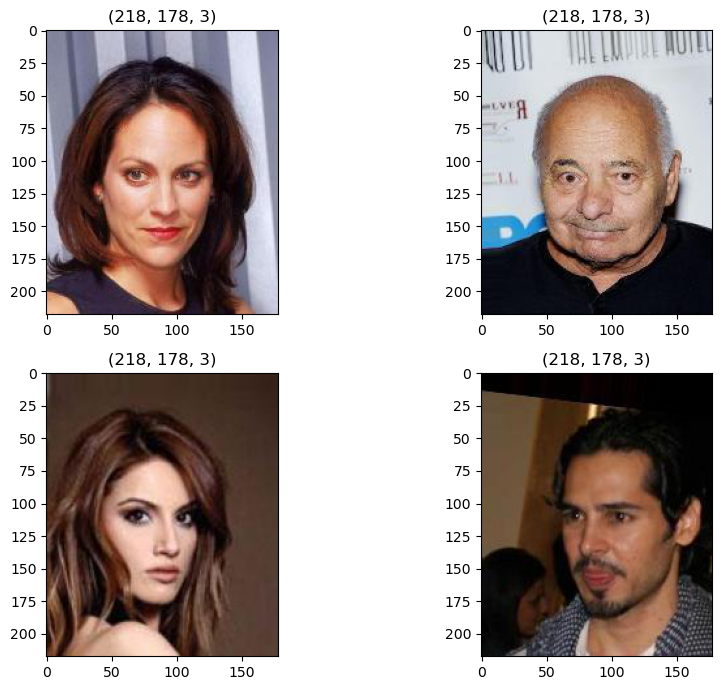

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

partitions = [0, 0, 1, 1]
males = [0, 1, 0, 1]

for i, (partition, male) in enumerate(zip(partitions, males)):
    ax = axes[i//2, i%2]
    index = df_filtered_cgp[(df_filtered_cgp['Partition'] == partition) & (df_filtered_cgp['Male'] == male)].index[0]
    image = plt.imread(folder_path + '/' + index)
    ax.imshow(image)
    ax.set_title(np.asarray(image, dtype=np.uint8).shape)

plt.tight_layout()


## 1.1 Dataloader

In [22]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [28]:
# Path ke file CSV yang berisi informasi gambar dan partisi
csv_path = r'C:\Users\USER\Documents\2023\AI\1. Gender Classification\celeba-gender-train.csv'

# Baca data dari file CSV
df = pd.read_csv(csv_path)
df["Unnamed: 0"]

0       000051.jpg
1       000052.jpg
2       000065.jpg
3       000166.jpg
4       000198.jpg
           ...    
4019    162465.jpg
4020    162571.jpg
4021    162637.jpg
4022    162722.jpg
4023    162729.jpg
Name: Unnamed: 0, Length: 4024, dtype: object

In [29]:
# Path ke folder dataset pelatihan
train_folder = r'C:\Users\USER\Documents\2023\AI\1. Gender Classification\Images'

# Path ke file CSV yang berisi informasi gambar dan partisi
csv_path = r'C:\Users\USER\Documents\2023\AI\1. Gender Classification\celeba-gender-train.csv'

# Baca data dari file CSV
df = pd.read_csv(csv_path)

# Inisialisasi list untuk menyimpan nilai saluran warna dari semua gambar
r_values = []
g_values = []
b_values = []

# Iterasi melalui data dalam DataFrame
with tqdm(desc='Process') as pbar:
    for index, row in df.iterrows():
        filename = row['Unnamed: 0']  # Ubah ini sesuai dengan kolom yang sesuai dalam DataFrame
        image = Image.open(os.path.join(train_folder, filename))
        image_array = np.array(image) / 255.0  # Normalisasi nilai piksel menjadi [0, 1]
        r_values.extend(image_array[:, :, 0].flatten())
        g_values.extend(image_array[:, :, 1].flatten())
        b_values.extend(image_array[:, :, 2].flatten())
        pbar.update(1)

# Hitung nilai rata-rata dan deviasi standar
mean_rgb = [np.mean(r_values), np.mean(g_values), np.mean(b_values)]
std_rgb = [np.std(r_values), np.std(g_values), np.std(b_values)]

print("Mean RGB:", mean_rgb)
print("Std RGB:", std_rgb)

Process: 0it [00:00, ?it/s]

Mean RGB: [0.5057785601183592, 0.4253581114168755, 0.38453132664143846]
Std RGB: [0.31147508858423206, 0.29129415284301585, 0.29110997976823205]


In [30]:
bs = 16
crop_size = 224

# Definisikan transformasi pra-pemrosesan untuk dataset pelatihan
train_transform = transforms.Compose([
    transforms.Resize(224),    # Resize gambar sesuai ukuran yang diinginkan
    transforms.RandomHorizontalFlip(p=0.5),  # Augmentasi: Flipping horizontal secara acak
    transforms.ToTensor(),           # Konversi ke Tensor
    transforms.Normalize(mean=mean_rgb, std=std_rgb)  # Normalisasi dengan rata-rata dan deviasi standar
])

eval_transform = transforms.Compose([
    transforms.Resize(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_rgb, std=std_rgb)
])

train_dataset = CelebaDataset(csv_path='celeba-gender-train.csv',
                              img_dir=folder_path+'/',
                              transform=train_transform)

valid_dataset = CelebaDataset(csv_path='celeba-gender-valid.csv',
                              img_dir=folder_path+'/',
                              transform=eval_transform)

test_dataset = CelebaDataset(csv_path='celeba-gender-test.csv',
                             img_dir=folder_path+'/',
                             transform=eval_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=bs,
                          shuffle=True,
                          num_workers=0)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=bs,
                          shuffle=False,
                          num_workers=0)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=bs,
                         shuffle=False,
                         num_workers=0)

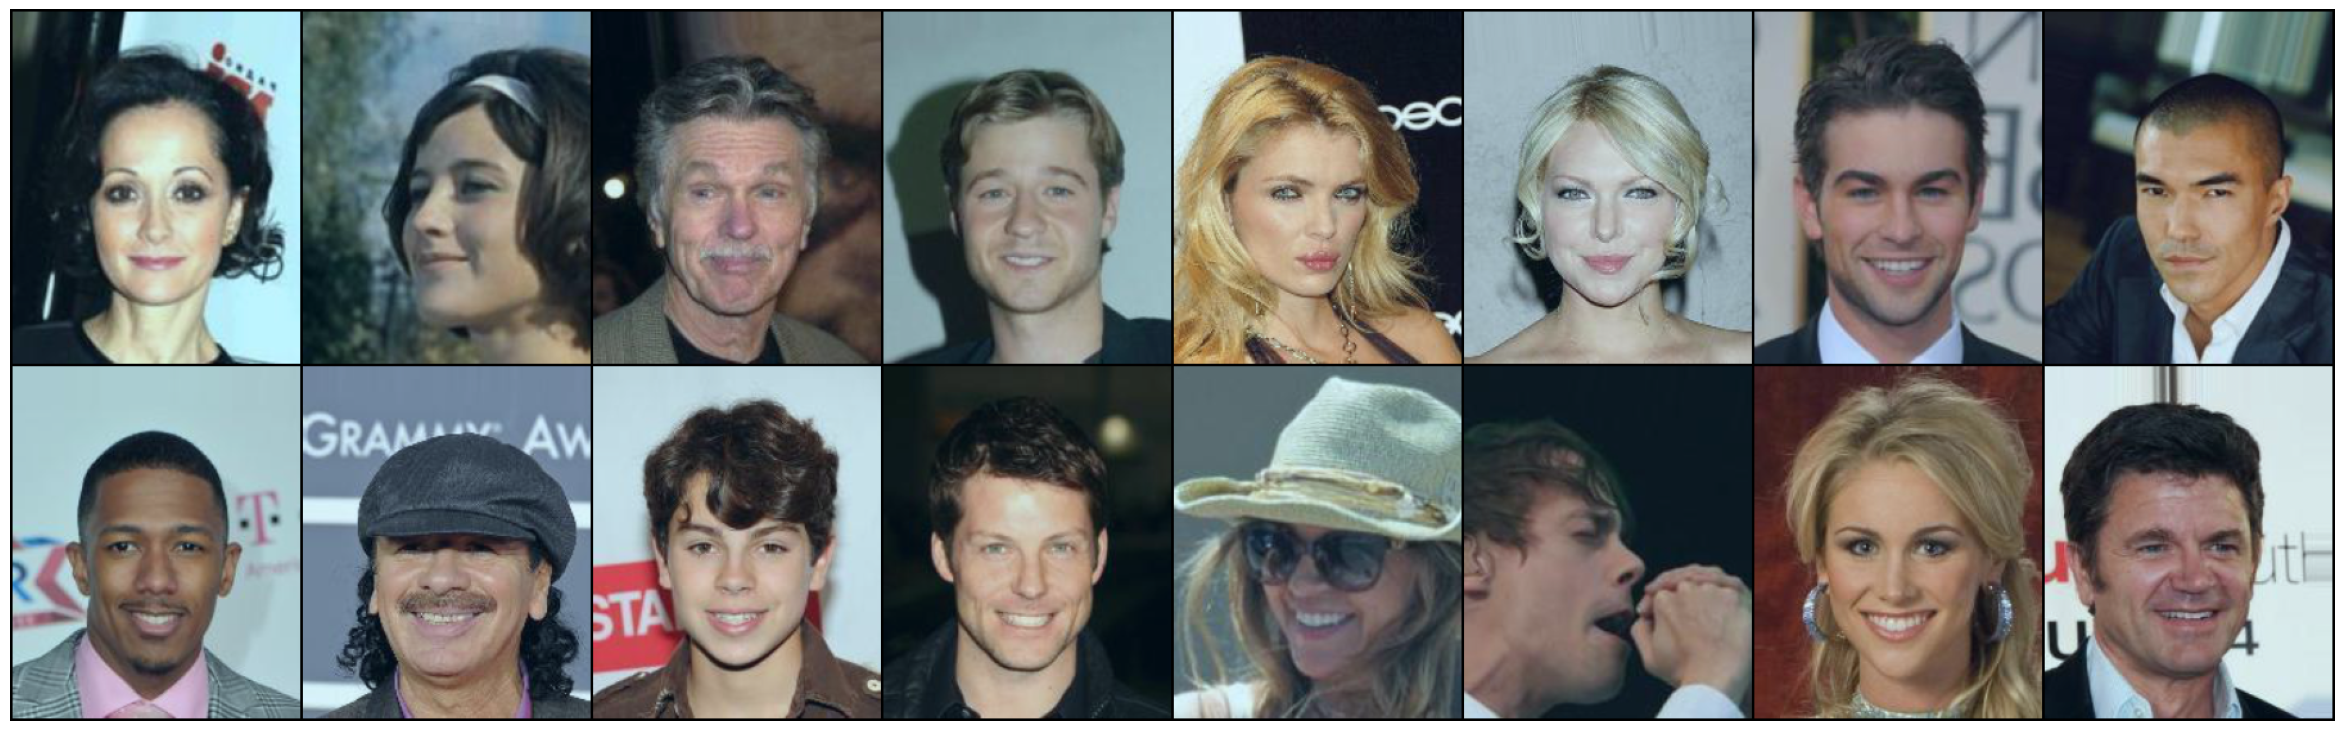

In [31]:
# Mengambil batch pertama dari train_loader
data_batch, _ = next(iter(train_loader))

# Menampilkan gambar-gambar dari batch
grid = vutils.make_grid(data_batch, nrow=8, padding=2, normalize=True)  # Menggabungkan gambar-gambar dalam grid
# Membuat plot dengan ukuran yang lebih besar
plt.figure(figsize=(30, 10))  # Ubah ukuran plot sesuai kebutuhan
plt.imshow(grid.permute(1, 2, 0))  # Menampilkan grid gambar
plt.axis('off')  # Menghilangkan sumbu pada plot
plt.show()

# 2. Modeling  
* architecture (mcoc)
* training

In [32]:
VGG_model = models.vgg16(weights= VGG16_Weights.IMAGENET1K_V1)
# VGG_model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)

In [33]:
VGG_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
for name, param in VGG_model.named_parameters():
    print(name, param.requires_grad)

features.0.weight True
features.0.bias True
features.2.weight True
features.2.bias True
features.5.weight True
features.5.bias True
features.7.weight True
features.7.bias True
features.10.weight True
features.10.bias True
features.12.weight True
features.12.bias True
features.14.weight True
features.14.bias True
features.17.weight True
features.17.bias True
features.19.weight True
features.19.bias True
features.21.weight True
features.21.bias True
features.24.weight True
features.24.bias True
features.26.weight True
features.26.bias True
features.28.weight True
features.28.bias True
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


In [35]:
for name, param in VGG_model.named_parameters():
    param.requires_grad = False

# define out classifier
binary_classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1),
    nn.Sigmoid()
)

# replace model class classifier attribute:
VGG_model.classifier = binary_classifier
VGG_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
for name, param in VGG_model.named_parameters():
    print(name, param.requires_grad)

features.0.weight False
features.0.bias False
features.2.weight False
features.2.bias False
features.5.weight False
features.5.bias False
features.7.weight False
features.7.bias False
features.10.weight False
features.10.bias False
features.12.weight False
features.12.bias False
features.14.weight False
features.14.bias False
features.17.weight False
features.17.bias False
features.19.weight False
features.19.bias False
features.21.weight False
features.21.bias False
features.24.weight False
features.24.bias False
features.26.weight False
features.26.bias False
features.28.weight False
features.28.bias False
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


#### Training Preparation 

In [37]:
# set up loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW(VGG_model.parameters(), lr=0.0001)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)  # pass in the parameters to be updated and learning rate

In [38]:
config = set_config({
    "output_size": 1,
    "batch_size": bs,
    "crop_size": crop_size
})

In [39]:
callback = Callback(VGG_model, config, early_stop_patience=5, outdir="model-1")

In [40]:
def loop_fn(mode, dataset, dataLoader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "val":
        model.eval()
    cost = correct = 0
#     test_acc = 0
    for feature, target in tqdm(dataLoader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target.unsqueeze(1).float())
        
        if mode == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        cost += loss.item() * feature.shape[0]
#         print(f"loss : {loss}")
#         print(f"loss.item() : {loss.item()}")
#         print(f"feature.shape : {feature.shape}")
#         print(f"feature.shape[0] : {feature.shape[0]}")
#         print(f"---")
    
#         correct += (output.argmax(dim=1) == target).sum().item()
        correct += (output.round().squeeze() == target).sum().item()
#         print(f"output.argmax() : {output.argmax(dim=1)}")
#         print(f"output.argmax(1) : {output.argmax(1)}")
#         print(f"output : {output:10.2f}")
#         print(f"output round : {output.round()}")
#         print(f"target : {target}")
#         print(f"output == target : {output.round() == target}")
#         print(f"shape ot : {(output.round() == target).shape}")
#         print(f"shape ot : {output.round().squeeze()}")
#         print(f"shape o : {output.round().shape}")
#         print(f"shape t : {target.shape}")

#         print(f"correct : {(output.round().squeeze() == target).sum().item()}")
#         print(f"correct sum : {correct}")
        
#         print(f"------base on loader-------")
#         test_acc += (output.argmax(dim=1) == target).sum().item()
#         print(f"acc_loader : {acc_loader}")
#         test_acc /= len(test_dataloader)
    cost = cost/len(dataset)
#     print(f"cost = {cost}")
    acc = correct/len(dataset)
    print(f"correct per epochs : {correct}")
    print(f"len(dataset) : {len(dataset)}")
    print(f"Acc : {correct/len(dataset)}")

#     Divide total accuracy by length of test dataloader (per batch)
#     test_acc /= len(test_dataloader)
    return cost, acc

Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 3600
len(dataset) : 4024
Acc : 0.8946322067594433


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 436
len(dataset) : 480
Acc : 0.9083333333333333

Epoch     1
Train_cost  = 0.2737 | Test_cost  = 0.2192 | Train_score = 0.8946 | Test_score = 0.9083 |


Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 3770
len(dataset) : 4024
Acc : 0.9368787276341949


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 449
len(dataset) : 480
Acc : 0.9354166666666667

Epoch     2
Train_cost  = 0.1636 | Test_cost  = 0.1686 | Train_score = 0.9369 | Test_score = 0.9354 |


Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 3841
len(dataset) : 4024
Acc : 0.9545228628230616


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 449
len(dataset) : 480
Acc : 0.9354166666666667

Epoch     3
Train_cost  = 0.1248 | Test_cost  = 0.1473 | Train_score = 0.9545 | Test_score = 0.9354 |
==> EarlyStop patience =  1 | Best test_score: 0.9354


Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 3873
len(dataset) : 4024
Acc : 0.9624751491053678


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 453
len(dataset) : 480
Acc : 0.94375

Epoch     4
Train_cost  = 0.1049 | Test_cost  = 0.1494 | Train_score = 0.9625 | Test_score = 0.9437 |


Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 3900
len(dataset) : 4024
Acc : 0.9691848906560636


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 449
len(dataset) : 480
Acc : 0.9354166666666667

Epoch     5
Train_cost  = 0.0831 | Test_cost  = 0.1931 | Train_score = 0.9692 | Test_score = 0.9354 |
==> EarlyStop patience =  1 | Best test_score: 0.9437


Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 3924
len(dataset) : 4024
Acc : 0.9751491053677932


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 453
len(dataset) : 480
Acc : 0.94375

Epoch     6
Train_cost  = 0.0661 | Test_cost  = 0.2123 | Train_score = 0.9751 | Test_score = 0.9437 |
==> EarlyStop patience =  2 | Best test_score: 0.9437


Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 3958
len(dataset) : 4024
Acc : 0.9835984095427436


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 450
len(dataset) : 480
Acc : 0.9375

Epoch     7
Train_cost  = 0.0495 | Test_cost  = 0.2433 | Train_score = 0.9836 | Test_score = 0.9375 |
==> EarlyStop patience =  3 | Best test_score: 0.9437


Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 3952
len(dataset) : 4024
Acc : 0.9821073558648111


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 457
len(dataset) : 480
Acc : 0.9520833333333333

Epoch     8
Train_cost  = 0.0500 | Test_cost  = 0.1844 | Train_score = 0.9821 | Test_score = 0.9521 |


Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 3980
len(dataset) : 4024
Acc : 0.989065606361829


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 455
len(dataset) : 480
Acc : 0.9479166666666666

Epoch     9
Train_cost  = 0.0319 | Test_cost  = 0.1956 | Train_score = 0.9891 | Test_score = 0.9479 |
==> EarlyStop patience =  1 | Best test_score: 0.9521


Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 3995
len(dataset) : 4024
Acc : 0.9927932405566601


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 454
len(dataset) : 480
Acc : 0.9458333333333333

Epoch    10
Train_cost  = 0.0206 | Test_cost  = 0.2961 | Train_score = 0.9928 | Test_score = 0.9458 |
==> EarlyStop patience =  2 | Best test_score: 0.9521


Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 3983
len(dataset) : 4024
Acc : 0.9898111332007953


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 450
len(dataset) : 480
Acc : 0.9375

Epoch    11
Train_cost  = 0.0311 | Test_cost  = 0.2621 | Train_score = 0.9898 | Test_score = 0.9375 |
==> EarlyStop patience =  3 | Best test_score: 0.9521


Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 3984
len(dataset) : 4024
Acc : 0.9900596421471173


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 448
len(dataset) : 480
Acc : 0.9333333333333333

Epoch    12
Train_cost  = 0.0290 | Test_cost  = 0.3691 | Train_score = 0.9901 | Test_score = 0.9333 |
==> EarlyStop patience =  4 | Best test_score: 0.9521


Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 3961
len(dataset) : 4024
Acc : 0.9843439363817097


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 440
len(dataset) : 480
Acc : 0.9166666666666666

Epoch    13
Train_cost  = 0.0524 | Test_cost  = 0.3876 | Train_score = 0.9843 | Test_score = 0.9167 |
==> EarlyStop patience =  5 | Best test_score: 0.9521
==> Execute Early Stopping at epoch: 13 | Best test_score: 0.9521
==> Best model is saved at model-1


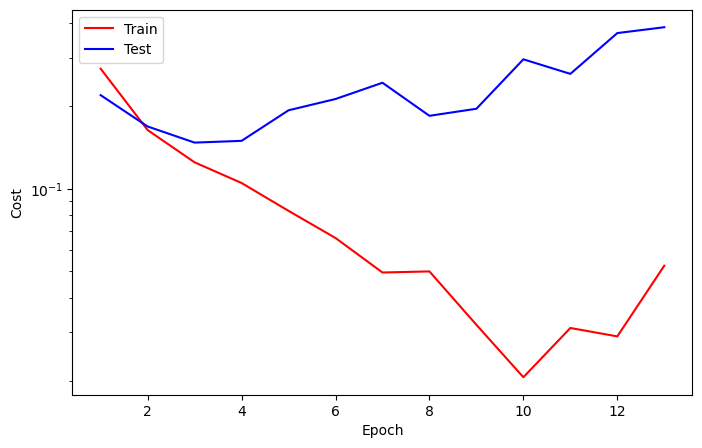

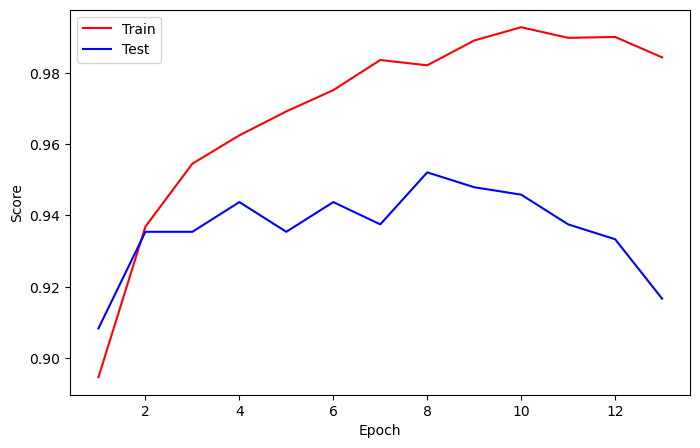

In [41]:
while True:
    train_cost, train_score = loop_fn("train", train_dataset, train_loader, VGG_model, criterion, optimizer, device)
    with torch.no_grad():
        val_cost, val_score = loop_fn("val", valid_dataset, valid_loader, VGG_model, criterion, optimizer, device)
        
    # logging
    callback.log(train_cost, val_cost, train_score, val_score)
    
    # checkpoint
    callback.save_checkpoint()
    
    # runtime plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # early stopping
    if callback.early_stopping(VGG_model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [47]:
for name, param in VGG_model.named_parameters():
    param.requires_grad = True
criterion = nn.BCELoss()
optimizer = optim.AdamW(VGG_model.parameters(), lr=0.001)
callback = Callback(VGG_model, config, early_stop_patience=2, outdir="model-2")
# callback.reset_early_stop()
# callback.early_stop_patience = 5

In [48]:
for name, param in VGG_model.named_parameters():
    print(name, param.requires_grad)

features.0.weight True
features.0.bias True
features.2.weight True
features.2.bias True
features.5.weight True
features.5.bias True
features.7.weight True
features.7.bias True
features.10.weight True
features.10.bias True
features.12.weight True
features.12.bias True
features.14.weight True
features.14.bias True
features.17.weight True
features.17.bias True
features.19.weight True
features.19.bias True
features.21.weight True
features.21.bias True
features.24.weight True
features.24.bias True
features.26.weight True
features.26.bias True
features.28.weight True
features.28.bias True
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 2351
len(dataset) : 4024
Acc : 0.5842445328031809


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 281
len(dataset) : 480
Acc : 0.5854166666666667

Epoch     1
Train_cost  = 41.5755 | Test_cost  = 41.4583 | Train_score = 0.5842 | Test_score = 0.5854 |


Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 2351
len(dataset) : 4024
Acc : 0.5842445328031809


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 281
len(dataset) : 480
Acc : 0.5854166666666667

Epoch     2
Train_cost  = 41.5755 | Test_cost  = 41.4583 | Train_score = 0.5842 | Test_score = 0.5854 |
==> EarlyStop patience =  1 | Best test_score: 0.5854


Train:   0%|          | 0/252 [00:00<?, ?it/s]

correct per epochs : 2351
len(dataset) : 4024
Acc : 0.5842445328031809


Val:   0%|          | 0/30 [00:00<?, ?it/s]

correct per epochs : 281
len(dataset) : 480
Acc : 0.5854166666666667

Epoch     3
Train_cost  = 41.5755 | Test_cost  = 41.4583 | Train_score = 0.5842 | Test_score = 0.5854 |
==> EarlyStop patience =  2 | Best test_score: 0.5854
==> Execute Early Stopping at epoch: 3 | Best test_score: 0.5854
==> Best model is saved at model-2


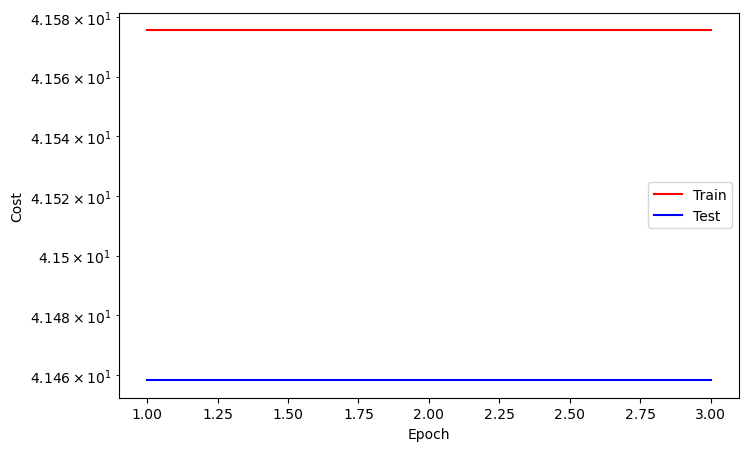

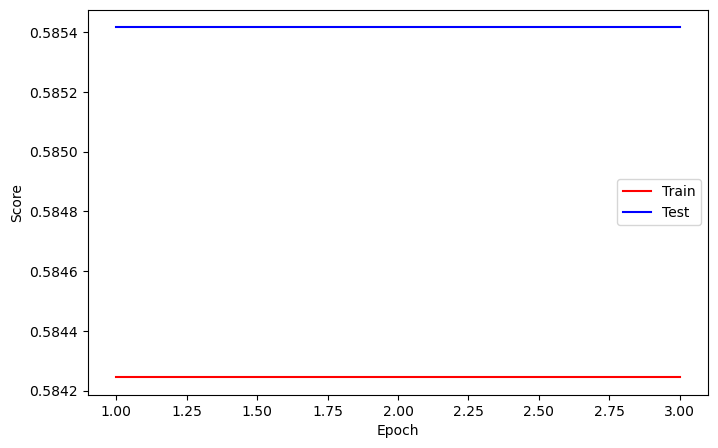

In [49]:
def loop_fn2(mode, dataset, dataLoader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "val":
        model.eval()
    cost = correct = 0
#     test_acc = 0
    for feature, target in tqdm(dataLoader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target.unsqueeze(1).float())
        
        if mode == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        cost += loss.item() * feature.shape[0]
#         print(f"loss : {loss}")
#         print(f"loss.item() : {loss.item()}")
#         print(f"feature.shape : {feature.shape}")
#         print(f"feature.shape[0] : {feature.shape[0]}")
#         print(f"---")
    
#         correct += (output.argmax(dim=1) == target).sum().item()
        correct += (output.round().squeeze() == target).sum().item()
#         print(f"output.argmax() : {output.argmax(dim=1)}")
#         print(f"output.argmax(1) : {output.argmax(1)}")
#         print(f"output : {output:10.2f}")
#         print(f"output round : {output.round()}")
#         print(f"target : {target}")
#         print(f"output == target : {output.round() == target}")
#         print(f"shape ot : {(output.round() == target).shape}")
#         print(f"shape ot : {output.round().squeeze()}")
#         print(f"shape o : {output.round().shape}")
#         print(f"shape t : {target.shape}")

#         print(f"correct : {(output.round().squeeze() == target).sum().item()}")
#         print(f"correct sum : {correct}")
        
#         print(f"------base on loader-------")
#         test_acc += (output.argmax(dim=1) == target).sum().item()
#         print(f"acc_loader : {acc_loader}")
#         test_acc /= len(test_dataloader)
    cost = cost/len(dataset)
#     print(f"cost = {cost}")
    acc = correct/len(dataset)
    print(f"correct per epochs : {correct}")
    print(f"len(dataset) : {len(dataset)}")
    print(f"Acc : {correct/len(dataset)}")

#     Divide total accuracy by length of test dataloader (per batch)
#     test_acc /= len(test_dataloader)
    return cost, acc

while True:
    train_cost, train_score = loop_fn2("train", train_dataset, train_loader, VGG_model, criterion, optimizer, device)
    with torch.no_grad():
        val_cost, val_score = loop_fn2("val", valid_dataset, valid_loader, VGG_model, criterion, optimizer, device)
        
    # logging
    callback.log(train_cost, val_cost, train_score, val_score)
    
    # checkpoint
    callback.save_checkpoint()
    
    # runtime plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # early stopping
    if callback.early_stopping(VGG_model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [38]:
torch.cuda.empty_cache()

In [51]:
feature, target = next(iter(test_loader))
feature, target = feature.to(device), target.to(device)

In [52]:
feature.shape

torch.Size([64, 3, 224, 224])

In [97]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=64,
                         shuffle=False,
                         num_workers=0)

In [102]:
loss, acc = 0, 0
with torch.inference_mode():
        for feature, target in test_loader:
            feature, target = feature.to(device), target.to(device)
            # Make predictions with the model
            y_pred = VGG_model(feature)
            print(f"y_pred : {(y_pred > 0.5).to(torch.float32).squeeze(dim=1).shape[0]}")
            print(f"target : {target.shape[0]}")
            # Accumulate the loss and accuracy values per batch
            loss += criterion(y_pred, target.unsqueeze(1).float())
            acc += ((y_pred > 0.5).to(torch.float32).squeeze(dim=1)==target).sum()/len(target)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(test_loader)
        acc /= len(test_loader)

y_pred : 64
target : 64
y_pred : 64
target : 64
y_pred : 64
target : 64
y_pred : 64
target : 64
y_pred : 64
target : 64
y_pred : 64
target : 64
y_pred : 64
target : 64
y_pred : 48
target : 48


In [103]:
loss, acc

(tensor(0.2271, device='cuda:0'), tensor(0.9043, device='cuda:0'))

In [104]:
feature, target = next(iter(test_loader))
feature, target = feature.to(device), target.to(device)

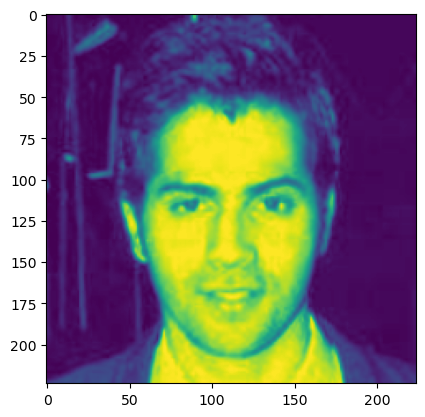

In [53]:
# plt.imshow(feature[0][0].permute(1, 2, 0).cpu())
plt.imshow(feature[0,0,:].cpu())

In [85]:
with torch.inference_mode():
    VGG_model.eval()
    output = VGG_model(feature)
    preds = (output > 0.5).to(torch.float32)
preds

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.93 GiB (GPU 0; 8.00 GiB total capacity; 2.17 GiB already allocated; 3.03 GiB free; 2.84 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [79]:
(preds.squeeze(dim=1)==target).sum()/len(target)

tensor(0.6562, device='cuda:0')

In [73]:
target

tensor([1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')

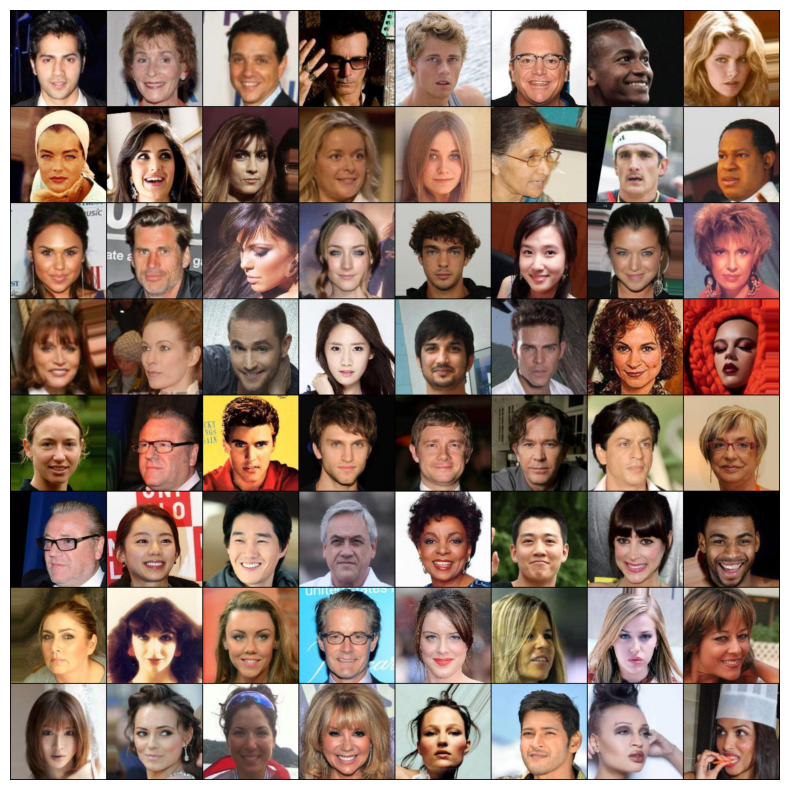

In [64]:
# Mengambil batch pertama dari train_loader
data_batch, _ = next(iter(test_loader))

# Menampilkan gambar-gambar dari batch
grid = vutils.make_grid(data_batch, nrow=8, padding=2, normalize=True)  # Menggabungkan gambar-gambar dalam grid
# Membuat plot dengan ukuran yang lebih besar
plt.figure(figsize=(30, 10))  # Ubah ukuran plot sesuai kebutuhan
plt.imshow(grid.permute(1, 2, 0))  # Menampilkan grid gambar
plt.axis('off')  # Menghilangkan sumbu pada plot
plt.show()

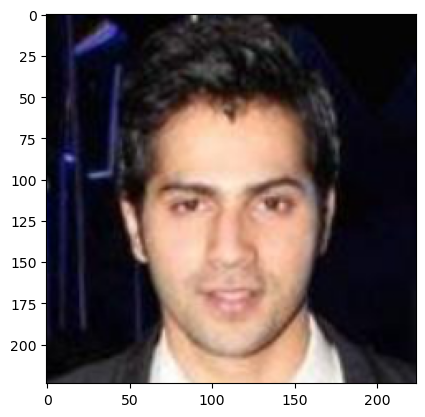

In [105]:
for index, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets

    break

plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [107]:
features.to(device)[0, None].shape

torch.Size([1, 3, 224, 224])

In [109]:
features.shape

torch.Size([64, 3, 224, 224])

In [113]:
features.shape

torch.Size([64, 3, 224, 224])

In [110]:
fig = plt.figure(figsize=(20,20))
for index, feature, target in enumerate(features):
    y_pred = model(features.to(device))
    
    fig.add_subplot(5, 4, index + 1)
    plt.title(f"Label: {target}\nPred: {(y_pred > 0.5).to(torch.float32)}")
    plt.axis('off')
    plt.imshow(np.transpose(feature, (1, 2, 0)))
    if index == 19:
        plt.show()
        break

ValueError: not enough values to unpack (expected 3, got 2)

<Figure size 2000x2000 with 0 Axes>

In [65]:
def convert_to_label(x):
    return [label for i in zip(x[0]) if pred==1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

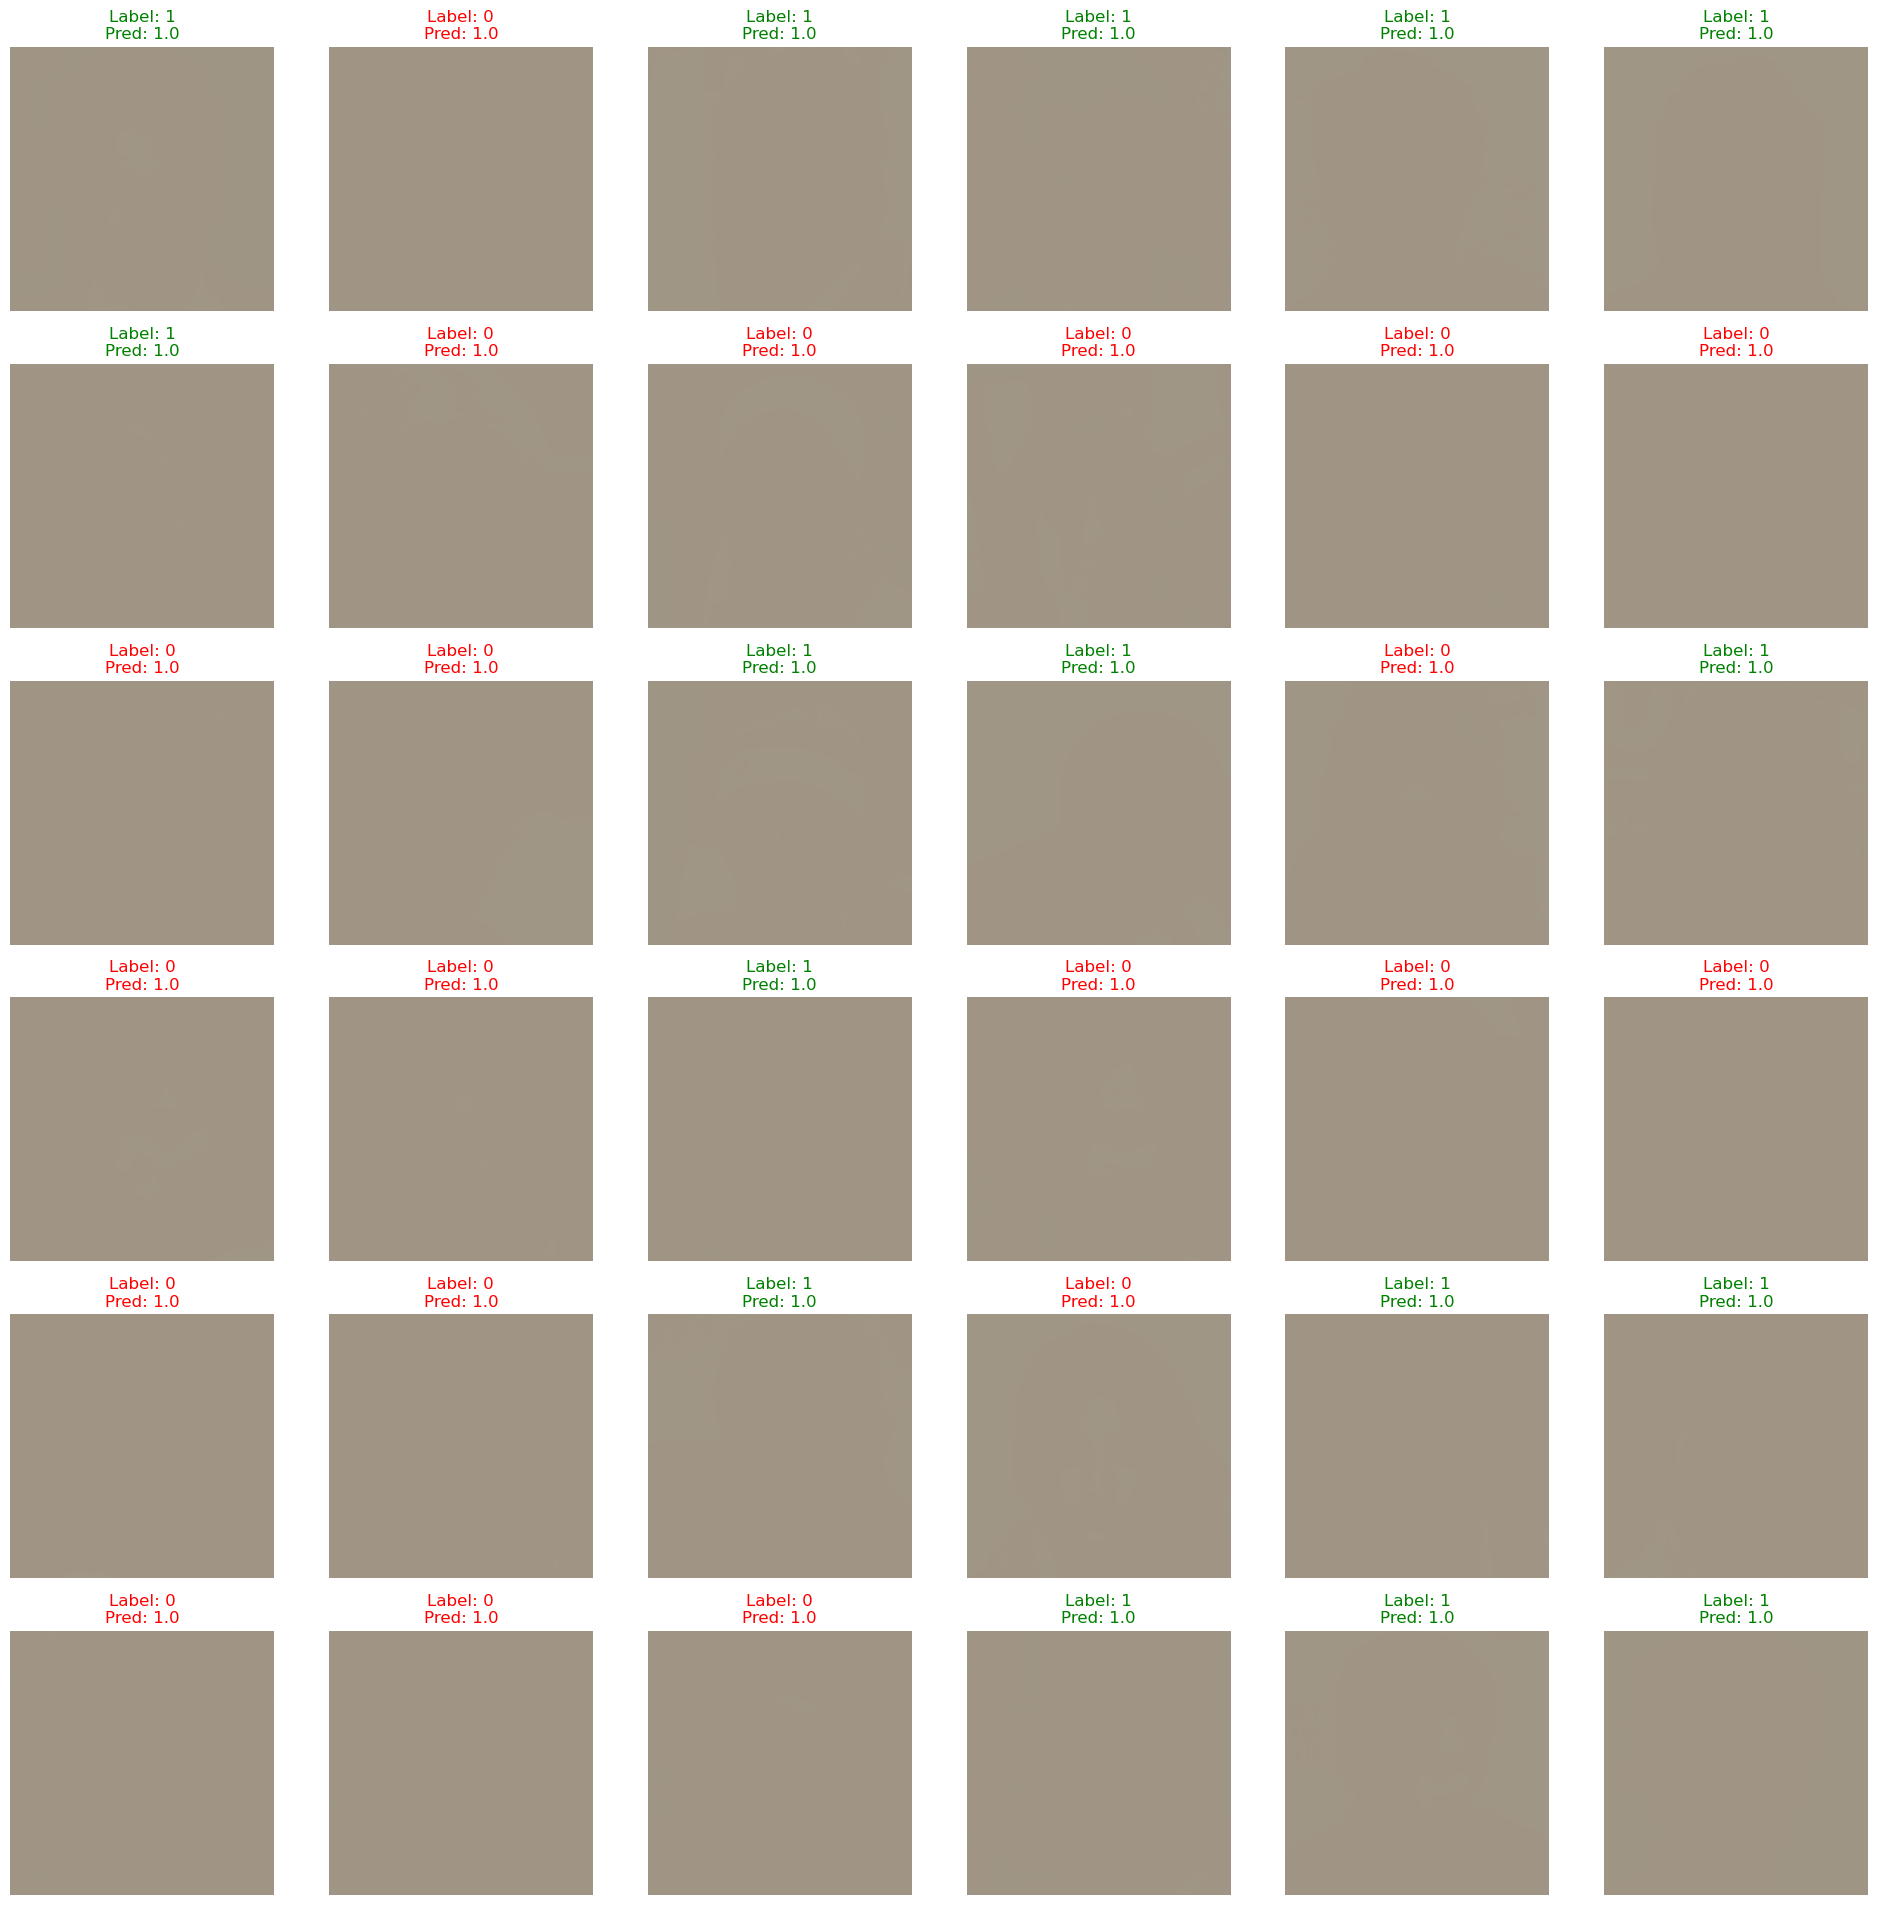

In [66]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {"color": 'r'} if (pred[0] != label).any() else {"color": 'g'}
    pred = pred[0]
    ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font);
    ax.axis('off')

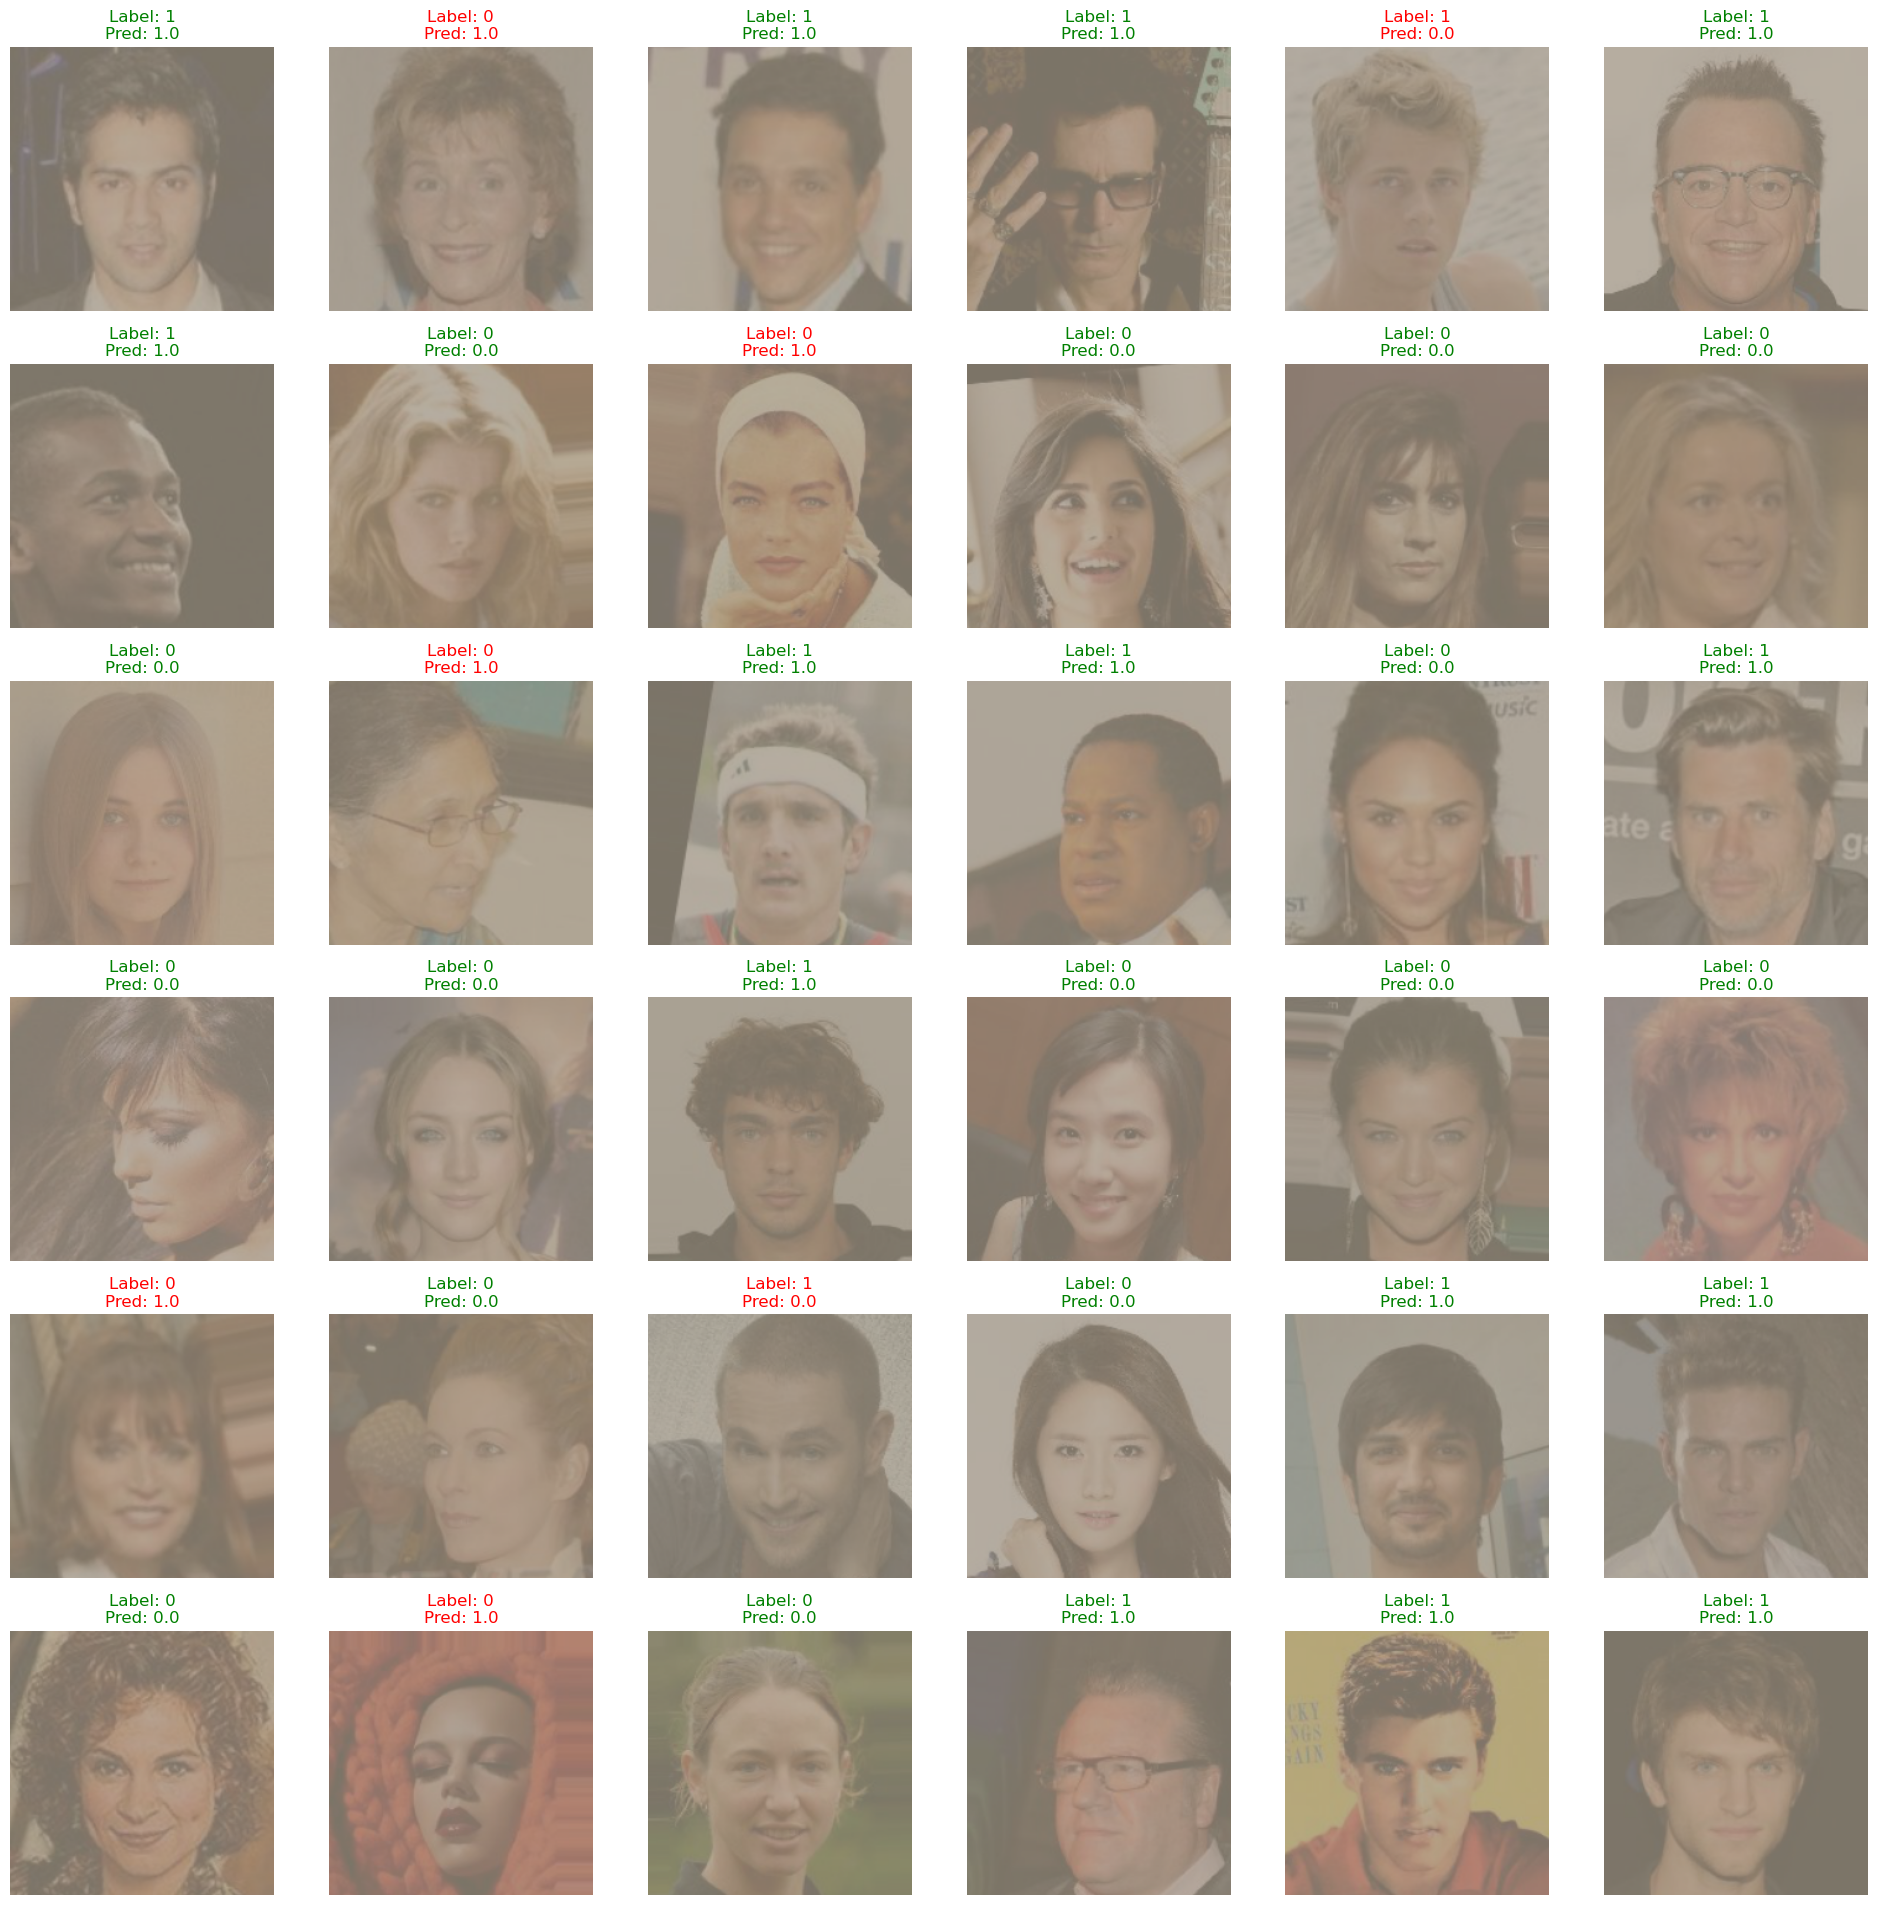

In [70]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
#     img = inverse_norm(img)  # Mengembalikan normalisasi
    img = transforms.ToPILImage()(img)  # Mengubah ke objek gambar PIL
    ax.imshow(img)
    font = {"color": 'r'} if (pred[0] != label).any() else {"color": 'g'}
    pred = pred[0]
    ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font)
    ax.axis('off')

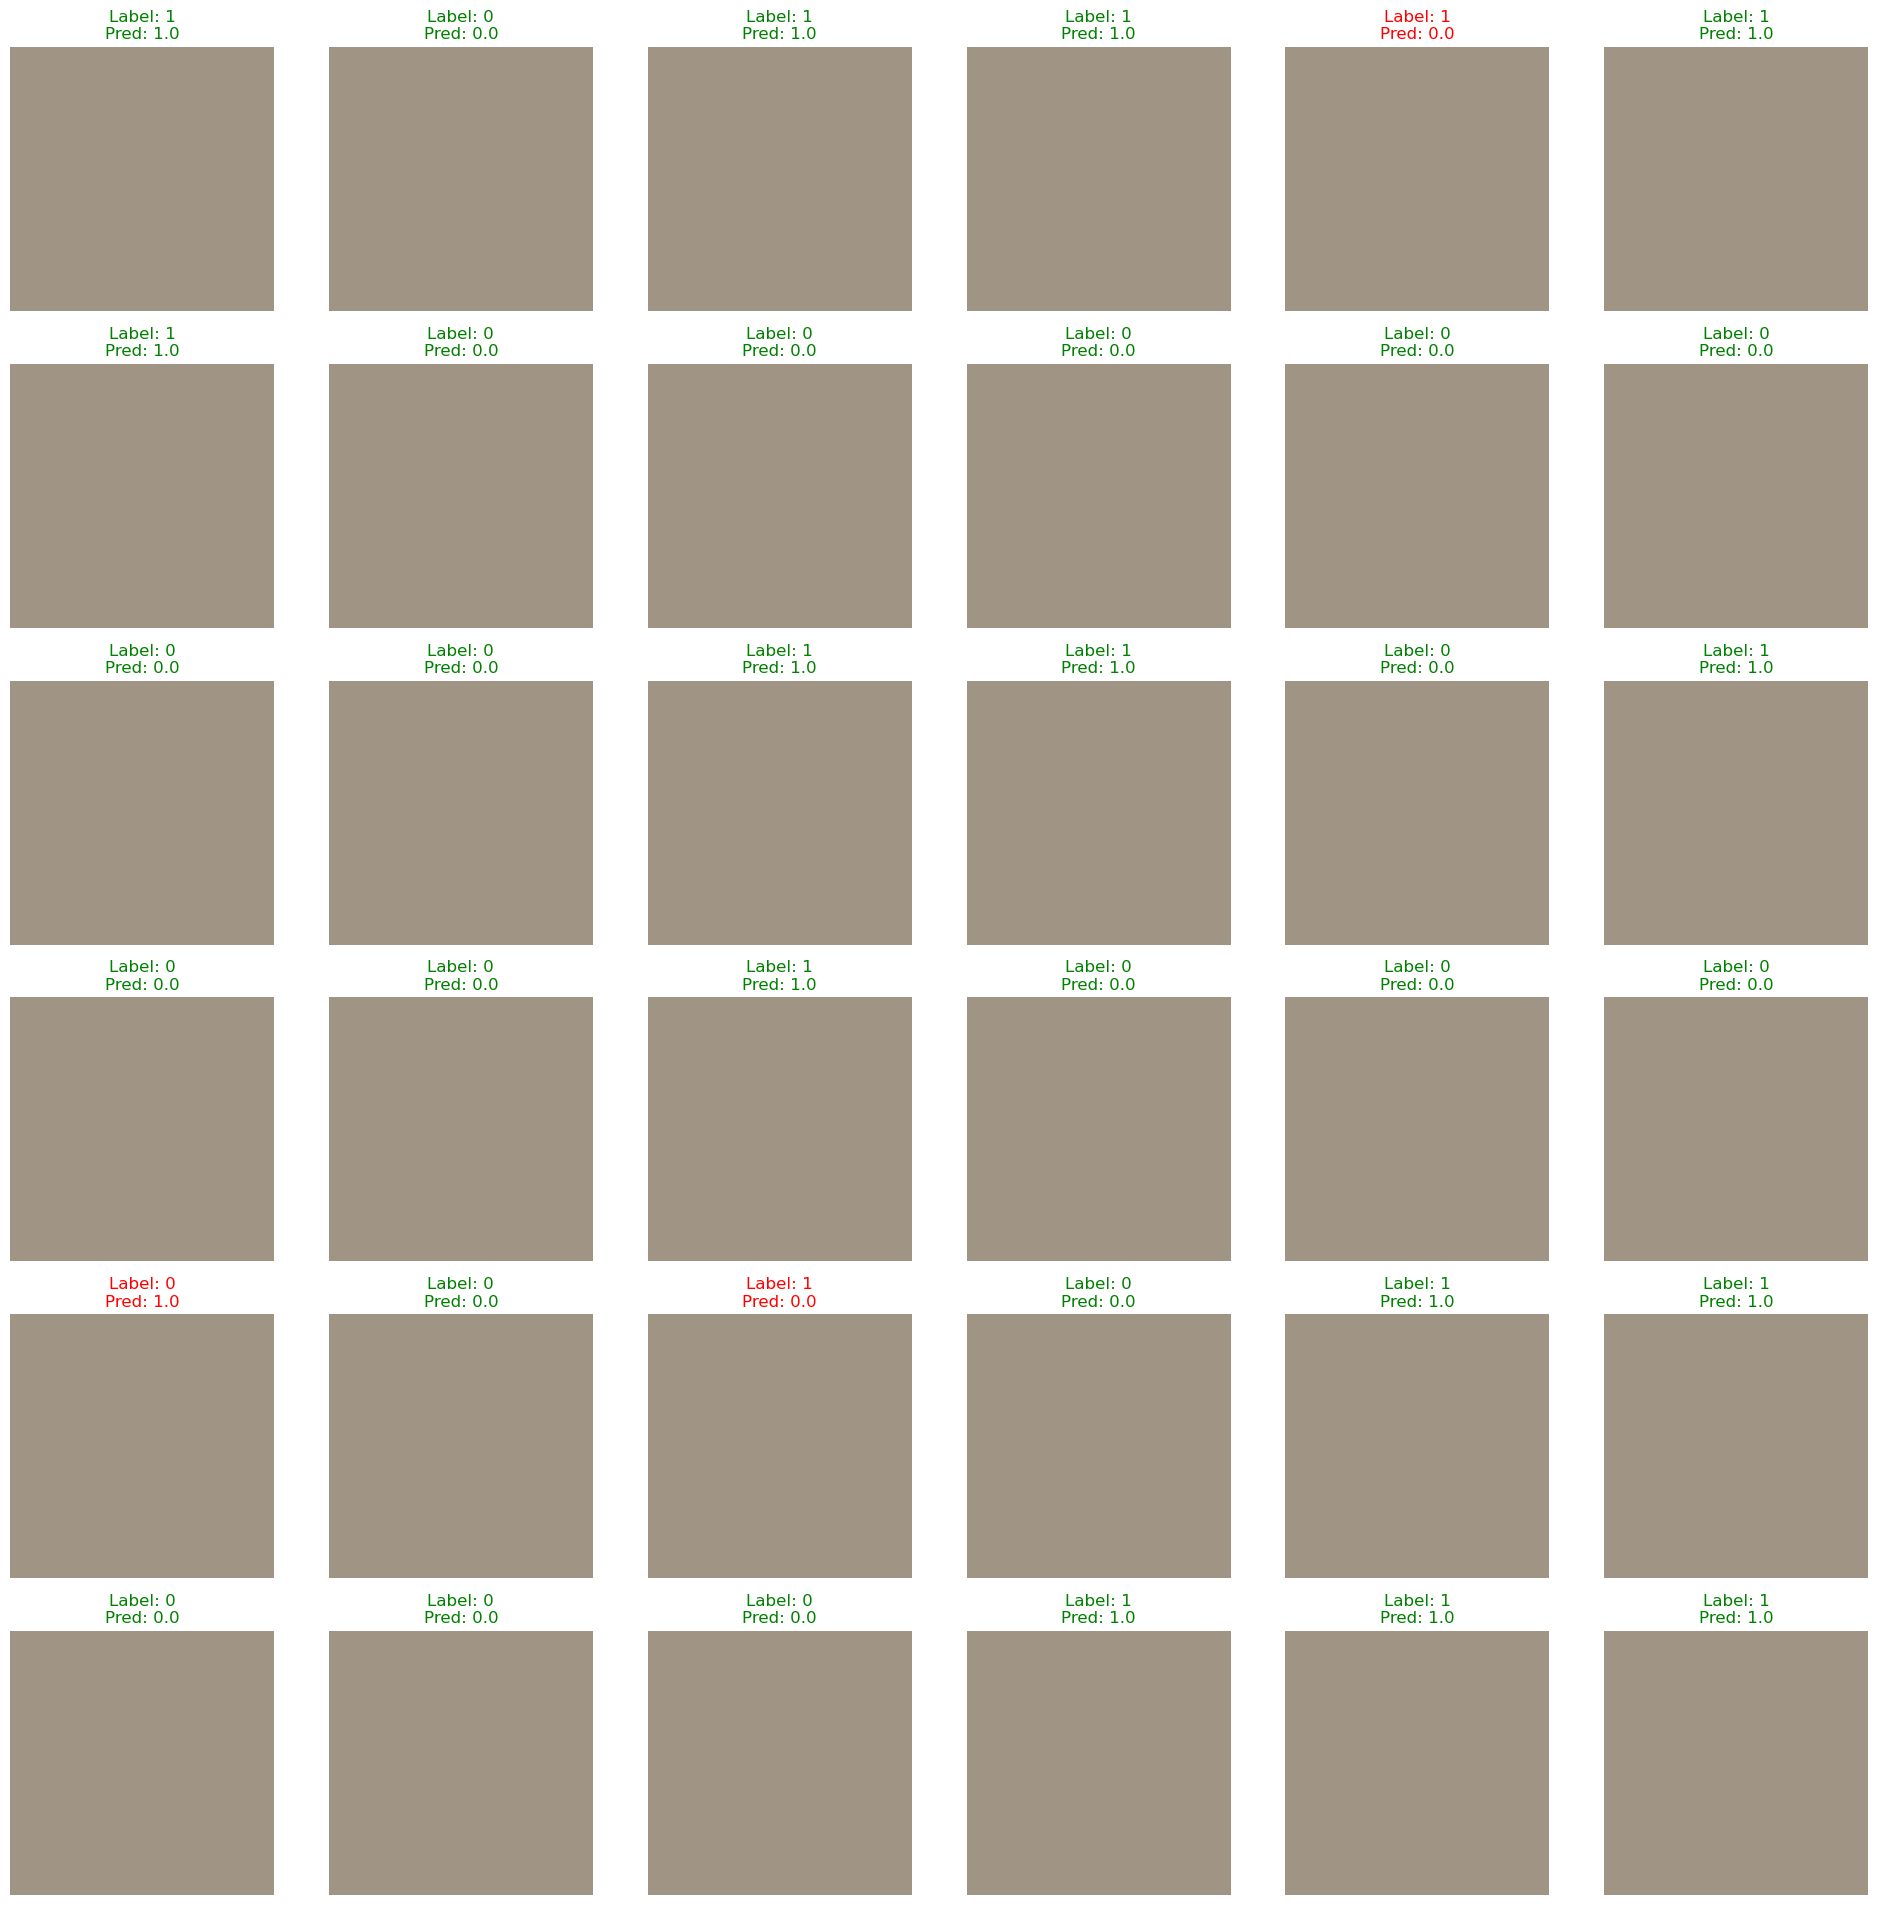

In [115]:
# Visualisasi hasil
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    img = transforms.ToPILImage()(img)
    ax.imshow(img)
    font = {"color": 'r'} if (pred[0] != label).any() else {"color": 'g'}
    pred = pred[0]
    ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font)
    ax.axis('off')

plt.show()

In [90]:
enumerate(train_loader)

0.5842445328031809

# 3. Evaluation
* plotting the result

# 4. Deployment
* save model

In [ ]:
# Pass the data through the model for a number of epochs (e.g. 100)
for epoch in range(epochs):
    # Put model in training mode (this is the default state of a model)
    model.train()
    
    # 1. Forward pass on train data using the forward() method inside
    y_preds = model(X_train)
    
    # 2. Calculate the loss (how different are the model's predictions to the true values)
    loss = loss

# ResNet

In [114]:


# Old weights with accuracy 76.130%
# resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# New weights with accuracy 80.858%
# resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
resnet50_model = resnet50(weights=ResNet50_Weights.DEFAULT)
# resnet50_model.to(device)
# Strings are also supported
# resnet50(weights="IMAGENET1K_V2")

# No weights - random initialization
# resnet50(weights=None)

In [115]:
resnet50_model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-7.4457e-03, -3.1783e-03,  3.7353e-02,  ...,  4.7936e-02,
                         -2.0325e-02,  8.8140e-03],
                        [-5.7435e-02,  4.4709e-02,  7.7509e-02,  ...,  8.8442e-02,
                          2.9346e-02, -5.8331e-02],
                        [ 6.8356e-02, -2.7044e-01,  4.0348e-01,  ..., -1.6491e-01,
                          2.1868e-01, -7.2909e-02],
                        ...,
                        [-1.0874e-01,  3.8148e-01, -4.5487e-01,  ...,  6.8366e-01,
                         -5.7855e-01,  2.2461e-01],
                        [ 2.5698e-02, -1.7703e-01,  6.4375e-01,  ...,  5.2644e-01,
                         -4.9317e-02, -6.8082e-02],
                        [ 4.5281e-02, -1.3072e-01,  1.7864e-02,  ..., -3.5753e-01,
                          1.8976e-01, -2.2302e-02]],
              
                       [[ 8.9197e-03,  4.8768e-03, -1.5356e-02,  ...,  8.6949e-02,
                         -6.5541

In [116]:
# define out classifier
fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1),
    nn.Sigmoid()
)

resnet50_model.fc = fc
resnet50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [117]:
resnet50_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [118]:
optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

In [119]:
config = set_config({
    "output_size": 1,
    "batch_size": bs,
    "crop_size": crop_size
})

In [120]:
callback_resnet = Callback(resnet50_model, config, early_stop_patience=20, outdir="model")

Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 3610
len(dataset) : 4024
Acc : 0.897117296222664


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 463
len(dataset) : 480
Acc : 0.9645833333333333

Epoch     1
Train_cost  = 0.2765 | Test_cost  = 0.0851 | Train_score = 0.8971 | Test_score = 0.9646 |


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 3954
len(dataset) : 4024
Acc : 0.9826043737574552


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 465
len(dataset) : 480
Acc : 0.96875

Epoch     2
Train_cost  = 0.0542 | Test_cost  = 0.0875 | Train_score = 0.9826 | Test_score = 0.9688 |


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 3988
len(dataset) : 4024
Acc : 0.9910536779324056


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 470
len(dataset) : 480
Acc : 0.9791666666666666

Epoch     3
Train_cost  = 0.0304 | Test_cost  = 0.0664 | Train_score = 0.9911 | Test_score = 0.9792 |


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4019
len(dataset) : 4024
Acc : 0.9987574552683897


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 465
len(dataset) : 480
Acc : 0.96875

Epoch     4
Train_cost  = 0.0068 | Test_cost  = 0.0845 | Train_score = 0.9988 | Test_score = 0.9688 |
==> EarlyStop patience =  1 | Best test_score: 0.9792


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4023
len(dataset) : 4024
Acc : 0.9997514910536779


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 467
len(dataset) : 480
Acc : 0.9729166666666667

Epoch     5
Train_cost  = 0.0029 | Test_cost  = 0.0759 | Train_score = 0.9998 | Test_score = 0.9729 |
==> EarlyStop patience =  2 | Best test_score: 0.9792


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4024
len(dataset) : 4024
Acc : 1.0


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 467
len(dataset) : 480
Acc : 0.9729166666666667

Epoch     6
Train_cost  = 0.0013 | Test_cost  = 0.0702 | Train_score = 1.0000 | Test_score = 0.9729 |
==> EarlyStop patience =  3 | Best test_score: 0.9792


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4019
len(dataset) : 4024
Acc : 0.9987574552683897


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 464
len(dataset) : 480
Acc : 0.9666666666666667

Epoch     7
Train_cost  = 0.0048 | Test_cost  = 0.1119 | Train_score = 0.9988 | Test_score = 0.9667 |
==> EarlyStop patience =  4 | Best test_score: 0.9792


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4014
len(dataset) : 4024
Acc : 0.9975149105367793


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 467
len(dataset) : 480
Acc : 0.9729166666666667

Epoch     8
Train_cost  = 0.0078 | Test_cost  = 0.0977 | Train_score = 0.9975 | Test_score = 0.9729 |
==> EarlyStop patience =  5 | Best test_score: 0.9792


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4020
len(dataset) : 4024
Acc : 0.9990059642147118


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 472
len(dataset) : 480
Acc : 0.9833333333333333

Epoch     9
Train_cost  = 0.0049 | Test_cost  = 0.0658 | Train_score = 0.9990 | Test_score = 0.9833 |


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4024
len(dataset) : 4024
Acc : 1.0


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 470
len(dataset) : 480
Acc : 0.9791666666666666

Epoch    10
Train_cost  = 0.0013 | Test_cost  = 0.0910 | Train_score = 1.0000 | Test_score = 0.9792 |
==> EarlyStop patience =  1 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4023
len(dataset) : 4024
Acc : 0.9997514910536779


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 466
len(dataset) : 480
Acc : 0.9708333333333333

Epoch    11
Train_cost  = 0.0010 | Test_cost  = 0.1335 | Train_score = 0.9998 | Test_score = 0.9708 |
==> EarlyStop patience =  2 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4022
len(dataset) : 4024
Acc : 0.9995029821073559


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 463
len(dataset) : 480
Acc : 0.9645833333333333

Epoch    12
Train_cost  = 0.0022 | Test_cost  = 0.1240 | Train_score = 0.9995 | Test_score = 0.9646 |
==> EarlyStop patience =  3 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4010
len(dataset) : 4024
Acc : 0.9965208747514911


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 469
len(dataset) : 480
Acc : 0.9770833333333333

Epoch    13
Train_cost  = 0.0099 | Test_cost  = 0.0655 | Train_score = 0.9965 | Test_score = 0.9771 |
==> EarlyStop patience =  4 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4010
len(dataset) : 4024
Acc : 0.9965208747514911


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 459
len(dataset) : 480
Acc : 0.95625

Epoch    14
Train_cost  = 0.0099 | Test_cost  = 0.0994 | Train_score = 0.9965 | Test_score = 0.9563 |
==> EarlyStop patience =  5 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4015
len(dataset) : 4024
Acc : 0.9977634194831014


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 470
len(dataset) : 480
Acc : 0.9791666666666666

Epoch    15
Train_cost  = 0.0083 | Test_cost  = 0.0636 | Train_score = 0.9978 | Test_score = 0.9792 |
==> EarlyStop patience =  6 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4024
len(dataset) : 4024
Acc : 1.0


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 468
len(dataset) : 480
Acc : 0.975

Epoch    16
Train_cost  = 0.0005 | Test_cost  = 0.0922 | Train_score = 1.0000 | Test_score = 0.9750 |
==> EarlyStop patience =  7 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4024
len(dataset) : 4024
Acc : 1.0


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 469
len(dataset) : 480
Acc : 0.9770833333333333

Epoch    17
Train_cost  = 0.0003 | Test_cost  = 0.0979 | Train_score = 1.0000 | Test_score = 0.9771 |
==> EarlyStop patience =  8 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4003
len(dataset) : 4024
Acc : 0.9947813121272365


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 469
len(dataset) : 480
Acc : 0.9770833333333333

Epoch    18
Train_cost  = 0.0144 | Test_cost  = 0.0699 | Train_score = 0.9948 | Test_score = 0.9771 |
==> EarlyStop patience =  9 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4016
len(dataset) : 4024
Acc : 0.9980119284294234


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 471
len(dataset) : 480
Acc : 0.98125

Epoch    19
Train_cost  = 0.0055 | Test_cost  = 0.1071 | Train_score = 0.9980 | Test_score = 0.9812 |
==> EarlyStop patience = 10 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4024
len(dataset) : 4024
Acc : 1.0


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 471
len(dataset) : 480
Acc : 0.98125

Epoch    20
Train_cost  = 0.0006 | Test_cost  = 0.0910 | Train_score = 1.0000 | Test_score = 0.9812 |


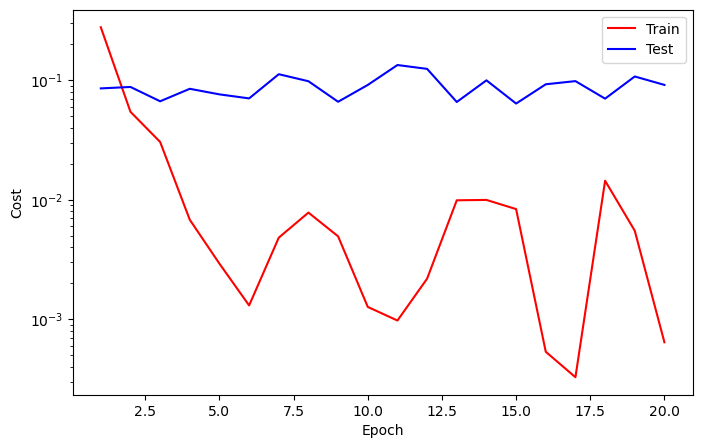

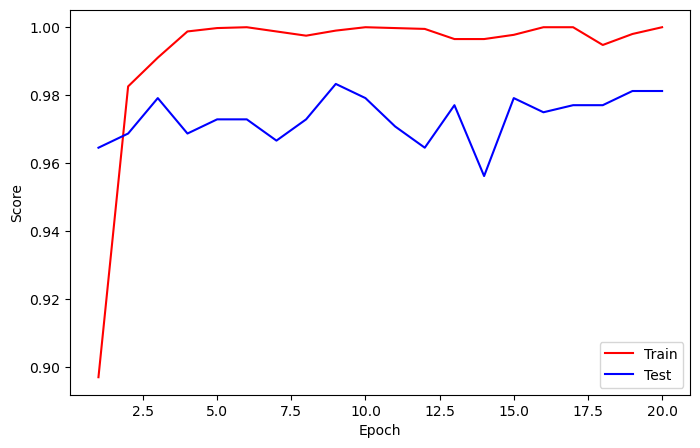

==> EarlyStop patience = 11 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4024
len(dataset) : 4024
Acc : 1.0


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 471
len(dataset) : 480
Acc : 0.98125

Epoch    21
Train_cost  = 0.0005 | Test_cost  = 0.0843 | Train_score = 1.0000 | Test_score = 0.9812 |
==> EarlyStop patience = 12 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4020
len(dataset) : 4024
Acc : 0.9990059642147118


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 468
len(dataset) : 480
Acc : 0.975

Epoch    22
Train_cost  = 0.0037 | Test_cost  = 0.1306 | Train_score = 0.9990 | Test_score = 0.9750 |
==> EarlyStop patience = 13 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4016
len(dataset) : 4024
Acc : 0.9980119284294234


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 469
len(dataset) : 480
Acc : 0.9770833333333333

Epoch    23
Train_cost  = 0.0048 | Test_cost  = 0.1007 | Train_score = 0.9980 | Test_score = 0.9771 |
==> EarlyStop patience = 14 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4008
len(dataset) : 4024
Acc : 0.9960238568588469


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 464
len(dataset) : 480
Acc : 0.9666666666666667

Epoch    24
Train_cost  = 0.0107 | Test_cost  = 0.1031 | Train_score = 0.9960 | Test_score = 0.9667 |
==> EarlyStop patience = 15 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4024
len(dataset) : 4024
Acc : 1.0


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 471
len(dataset) : 480
Acc : 0.98125

Epoch    25
Train_cost  = 0.0014 | Test_cost  = 0.0883 | Train_score = 1.0000 | Test_score = 0.9812 |
==> EarlyStop patience = 16 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4022
len(dataset) : 4024
Acc : 0.9995029821073559


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 471
len(dataset) : 480
Acc : 0.98125

Epoch    26
Train_cost  = 0.0010 | Test_cost  = 0.0940 | Train_score = 0.9995 | Test_score = 0.9812 |
==> EarlyStop patience = 17 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4021
len(dataset) : 4024
Acc : 0.9992544731610338


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 472
len(dataset) : 480
Acc : 0.9833333333333333

Epoch    27
Train_cost  = 0.0021 | Test_cost  = 0.0641 | Train_score = 0.9993 | Test_score = 0.9833 |
==> EarlyStop patience = 18 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4017
len(dataset) : 4024
Acc : 0.9982604373757455


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 469
len(dataset) : 480
Acc : 0.9770833333333333

Epoch    28
Train_cost  = 0.0042 | Test_cost  = 0.0799 | Train_score = 0.9983 | Test_score = 0.9771 |
==> EarlyStop patience = 19 | Best test_score: 0.9833


Train:   0%|          | 0/63 [00:00<?, ?it/s]

correct per epochs : 4022
len(dataset) : 4024
Acc : 0.9995029821073559


Val:   0%|          | 0/8 [00:00<?, ?it/s]

correct per epochs : 468
len(dataset) : 480
Acc : 0.975

Epoch    29
Train_cost  = 0.0031 | Test_cost  = 0.1240 | Train_score = 0.9995 | Test_score = 0.9750 |
==> EarlyStop patience = 20 | Best test_score: 0.9833
==> Execute Early Stopping at epoch: 29 | Best test_score: 0.9833
==> Best model is saved at model


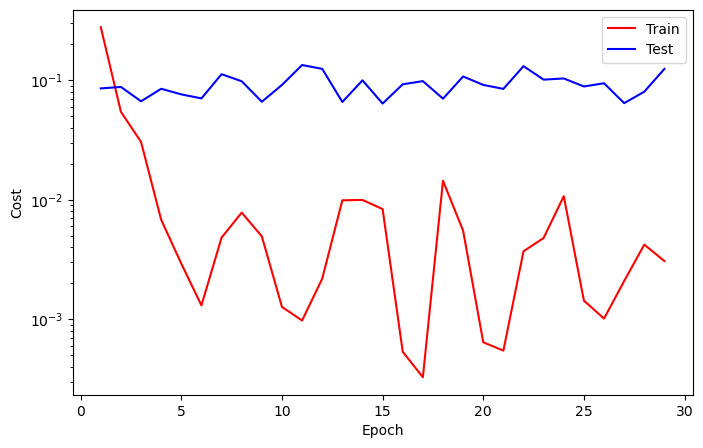

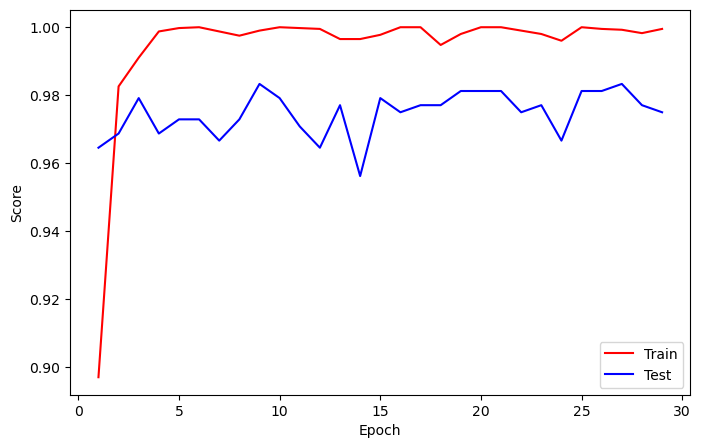

In [121]:
while True:
    train_cost_resnet, train_score_resnet = loop_fn("train", train_dataset, train_loader, resnet50_model, criterion, optimizer, device)
    with torch.no_grad():
        val_cost_resnet, val_score_resnet = loop_fn("val", valid_dataset, valid_loader, resnet50_model, criterion, optimizer, device)
        
    # logging
    callback_resnet.log(train_cost_resnet, val_cost_resnet, train_score_resnet, val_score_resnet)
    
    # checkpoint
    callback_resnet.save_checkpoint()
    
    # runtime plotting
    callback_resnet.cost_runtime_plotting()
    callback_resnet.score_runtime_plotting()
    
    # early stopping
    if callback_resnet.early_stopping(resnet50_model, monitor="test_score"):
        callback_resnet.plot_cost()
        callback_resnet.plot_score()
        break

In [122]:
loss, acc = 0, 0
with torch.inference_mode():
        for feature, target in test_loader:
            feature, target = feature.to(device), target.to(device)
            # Make predictions with the model
            y_pred = resnet50_model(feature)
#             print(f"y_pred : {(y_pred > 0.5).to(torch.float32).squeeze(dim=1).shape[0]}")
#             print(f"target : {target.shape[0]}")
            # Accumulate the loss and accuracy values per batch
            loss += criterion(y_pred, target.unsqueeze(1).float())
            acc += ((y_pred > 0.5).to(torch.float32).squeeze(dim=1)==target).sum()/len(target)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(test_loader)
        acc /= len(test_loader)

In [123]:
loss, acc

(tensor(0.1195, device='cuda:0'), tensor(0.9661, device='cuda:0'))

In [44]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 5

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
#         print(f"batch : {batch}")
#         print(f"X : {X.shape}")
#         print(f"y : {y}")
        resnet50_model.train() 
        # 1. Forward pass
        y_pred = resnet50_model(X)
#         print(f"y_pred : {y_pred.shape}")
#         print(f"y : {y.unsqueeze(1).float().shape}")

        # 2. Calculate loss (per batch)
        loss = criterion(y_pred, y.unsqueeze(1).float())
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
#         if batch % 64 == 0:
#             print(f"Looked at {batch * len(X)}/{len(resnet50_model.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_loader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    resnet50_model.eval()
    with torch.inference_mode():
        for X, y in valid_loader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = resnet50_model(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += criterion(test_pred, y.unsqueeze(1).float()) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(valid_loader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(valid_loader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(resnet50_model.parameters()).device))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-------

Train loss: 0.18311 | Test loss: 0.09834, Test acc: 58.59%

Epoch: 1
-------

Train loss: 0.07638 | Test loss: 0.18431, Test acc: 58.59%

Epoch: 2
-------

Train loss: 0.05531 | Test loss: 0.28609, Test acc: 58.59%

Epoch: 3
-------

Train loss: 0.03795 | Test loss: 0.13275, Test acc: 58.59%

Epoch: 4
-------

Train loss: 0.03602 | Test loss: 0.05039, Test acc: 58.59%

Train time on cuda:0: 72.662 seconds


# Save Weight 

In [ ]:
import os
os.makedirs("model", exist_ok=True)
model.state_dict()
torch.save(model.state_dict(), ".../weights.pth")
log = {
    "train_cost": train_cost,
    "test_cost": test_cost,
    "train_acc": train_acc,
    "test_acc": test_acc
}
torch.save(log, ".../logs.pth")

# Load Model 

In [ ]:
model = nn.Sequential(
    nn.Linear(4, 3),
    nn.ReLU(),
    nn.Linear(3, 4),
    nn.ReLU(),
    nn.Linear(4, 3),
    nn.Sigmoid()
)
weights = torch.load("../weights.pth", map_location="cpu")
model.load_state_dict(weights)
modelel = model.to(device)
with torch.no_grad():
    model.eval()
    output = model(X_test)
    pred = output.argmax(1)
    acc = (y_test == pred).to(torch.float32).mean()
acc

####  how to denormalize image

In [ ]:
# Definisikan transformasi pra-pemrosesan untuk dataset pelatihan
train_preprocess = transforms.Compose([
    transforms.Resize(224),    # Resize gambar sesuai ukuran yang diinginkan
    transforms.RandomHorizontalFlip(p=0.5),  # Augmentasi: Flipping horizontal secara acak
    transforms.ToTensor(),           # Konversi ke Tensor
    transforms.Normalize(mean=[0.506, 0.426, 0.385], std=[0.3112, 0.291, 0.290])  # Normalisasi dengan rata-rata dan deviasi standar
])

# Definisikan transformasi pra-pemrosesan untuk dataset validasi dan pengujian
eval_preprocess = transforms.Compose([
    transforms.Resize(224),    # Resize gambar sesuai ukuran yang diinginkan
    transforms.ToTensor(),           # Konversi ke Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisasi dengan rata-rata dan deviasi standar
])

# Load gambar dataset pelatihan
train_image = Image.open(r'C:\Users\USER\Documents\2023\AI\1. Gender Classification\Images\000051.jpg')  # Ganti dengan path gambar pelatihan Anda
processed_train_image = train_preprocess(train_image)

# Mendeklarasikan invers transformasi normalisasi
inv_normalize = transforms.Normalize(
    mean=[-0.5067703734470237 / 0.3110572110018872, -0.42661704610077494 / 0.29111213054458934, -0.3853664028877897 / 0.29097610138978547],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# Mengaplikasikan invers transformasi dan menampilkan gambar
inversed_image = inv_normalize(processed_train_image)
inversed_image = transforms.ToPILImage()(inversed_image)

# Menampilkan gambar asli setelah dinormalisasi
plt.imshow(inversed_image)
plt.show()